# Slash Product Image Classifer

An image classification model using transfer learning with the MobileNetV2 architecture pre-trained on ImageNet is built to be able to classify the products according to the product categories on the application. Transfer learning worked best as the application does not have enough pictures yet to train a deep learning model from scratch.

# 1. Data Preparation

## 1.1 Visualizing the Data

The dataset we train the model on exists in the data directory. It contains 8 subfolders, each folder is a category of products on the application. These categories are:
1. accessories
2. artifcats
3. beauty 
4. fashion
5. games
6. home
7. nutrition
8. stationary


In [110]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing import image

def plot_images(directory, num_images=4):
    # get a list of all files in the directory
    files = os.listdir(directory)
    
    # select a random sample of files
    sample_files = np.random.choice(files, num_images)
    
    # plot the selected images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, filename in enumerate(sample_files):
        img_path = os.path.join(directory, filename)
        img = image.load_img(img_path, target_size=(224, 224))  # load and resize the image
        axes[i].imshow(img)
        axes[i].axis('off') 
        axes[i].set_title(directory[5:] + ': ' + filename)  # set title as the filename
    plt.show()

Below is the visualization of a sample of the pictures found in each category

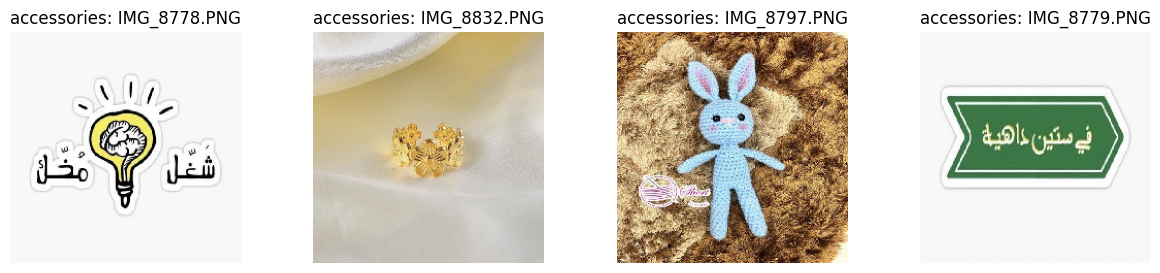

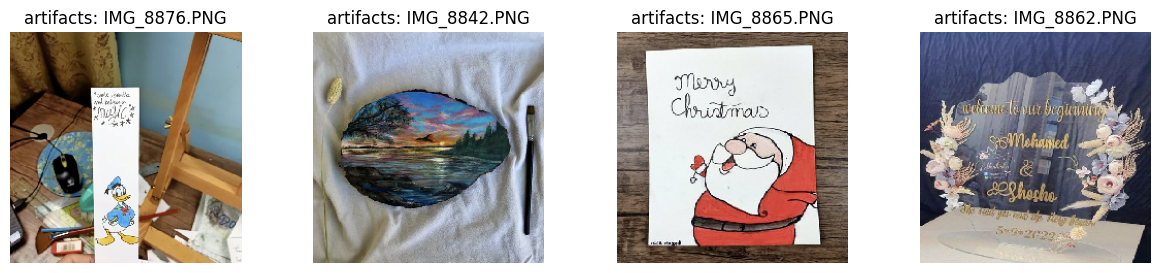

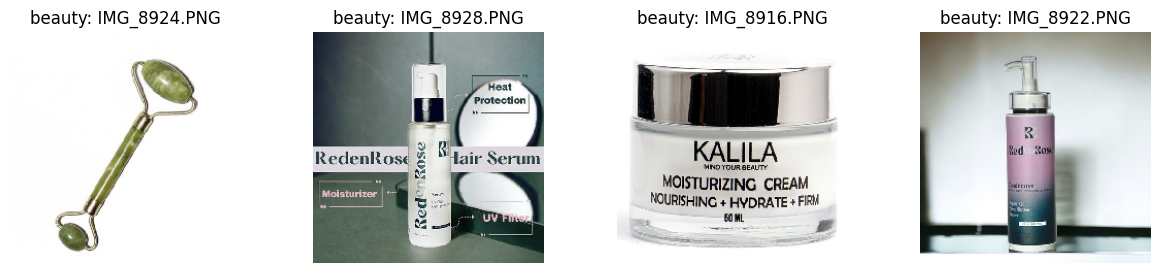

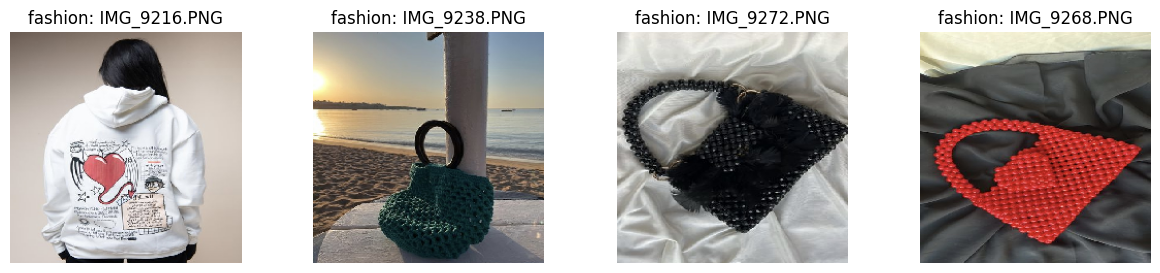

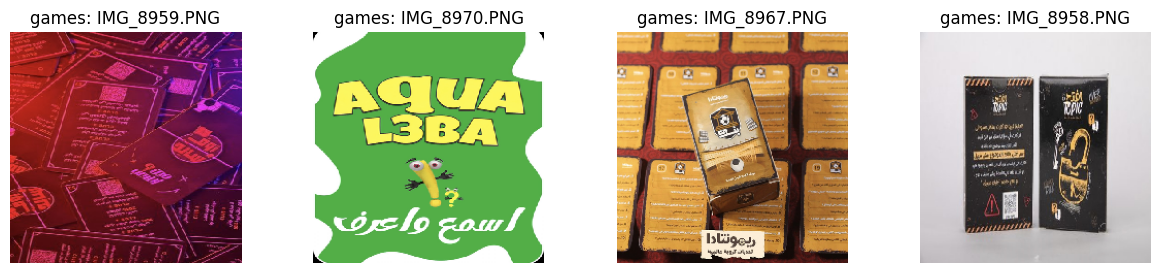

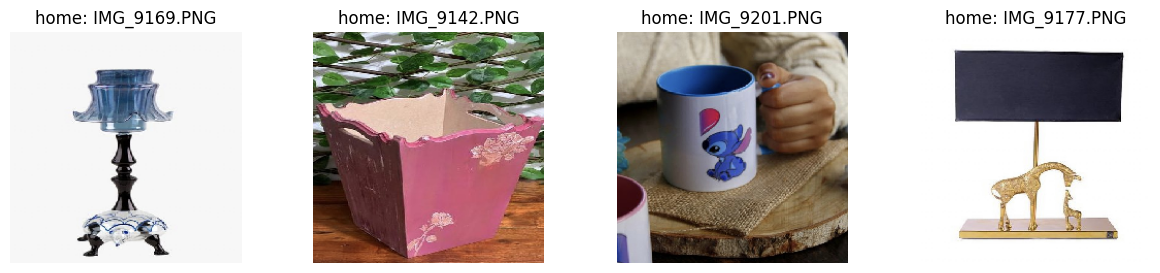

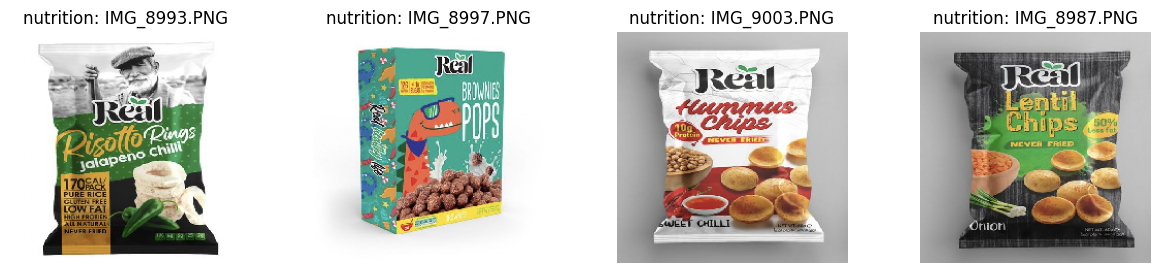

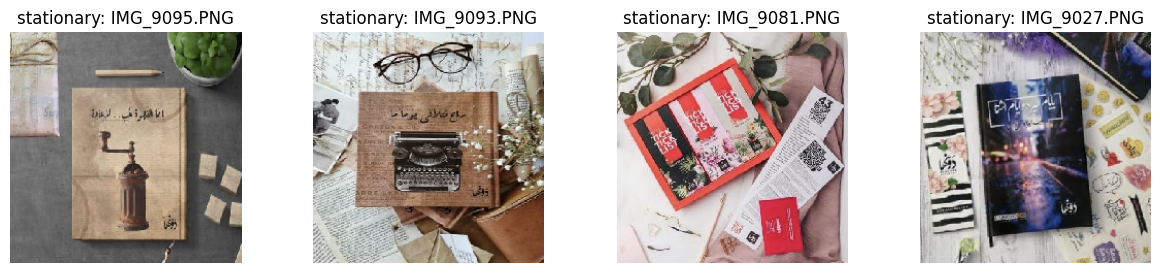

In [111]:
plot_images('data/accessories') 
plot_images('data/artifacts') 
plot_images('data/beauty') 
plot_images('data/fashion') 
plot_images('data/games') 
plot_images('data/home') 
plot_images('data/nutrition') 
plot_images('data/stationary') 


## 1.2 Augmenting and Normalizing the Data

Data augmentation and normalization is done using the ImageDataGenerator. 

Data augmentation involves applying various transformations to the images in the training dataset, such as rotation, shifting, zooming, and flipping. It is done to increase the diversity of the dataset, which decreases chances of the model overfitting and enables the model to generalize better to unseen data. 

Dara normalization rescales the pixel values of the images to a common scale [0, 1].  This ensures the input features have similar ranges, which can facilitate the training process and improve the model's convergence. It prevents issues like vanishing or exploding gradients, which can hinder the model's ability to learn effectively.

In [112]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = 'data'  # define the directory where the training data is stored

# set hyperparameters 
batch_size = 32  # number of samples per gradient update
image_size = (224, 224)  # size to which all images will be resized
num_classes = 8  # number of classes (folders) in the data directory
epochs = 10  # number of epochs for training


In [113]:
datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to the range [0, 1]
    rotation_range=20,  # degree range for random rotations
    width_shift_range=0.2,  # range for random horizontal shifts
    height_shift_range=0.2,  # range for random vertical shifts
    zoom_range=0.2,  # range for random zoom
    horizontal_flip=True,  # randomly flip inputs horizontally
    fill_mode='nearest',  # strategy for filling in newly created pixels
    validation_split=0.2 
)

We then define the data generators that will be used to train and validate the model. We use the previously defined hyperparamaters as well as define  (class_mode="categorical") so that the labels are provided in a one-hot encoded format. 

In [114]:
# data generator
generator = datagen.flow_from_directory(
    data_dir,  
    target_size=image_size,  # size to which all images will be resized
    batch_size=batch_size,  # number of samples per gradient update
    class_mode='categorical',  # type of label arrays returned by the generator
    subset='training'  
)

validation_generator = datagen.flow_from_directory(
    data_dir, 
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation' 
)


Found 335 images belonging to 8 classes.
Found 80 images belonging to 8 classes.


# 2. Model Training

## 2.1 Fine-tuning the Model

We use the MobileNetV2 model when building our model, which is loaded with pre-trained weights from ImageNet. The (include_top=False) argument specifies that we do not want to include the fully connected classification layers at the top of the network, which are responsible for classifying images into 1000 ImageNet classes. This allows us to add our own custom classification layers suited to our specific task.

In [115]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

To adjust the pre-trained MobileNetV2 on our own classification problem, the following steps are performed:

1. Load the pre-trained MobileNetV2 while excluding the top layers.
2. Get the output tensor of the MobileNetV2 base model, which represents the features extracted from the input images.
3. Add the Global Average Pooling 2D layer computes the average value of each feature map in the input tensor. This reduces the spatial dimensions of the features and helps in reducing the number of parameters in the following layers.
5. Add a fully connected layer to act as a feature extractor.
6. Add a fully connected layer with the number of classes in our dataset to classify the images.

In [116]:
# load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False)

# add custom classification head on top of the pre-defined base
x = base_model.output
x = GlobalAveragePooling2D()(x)  # global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # fully connected layer with ReLU activation
predictions = Dense(num_classes, activation='softmax')(x)  # output layer with softmax activation


## 2.2 Creating the Model

In [117]:
# create the model
model = Model(inputs=base_model.input, outputs=predictions)

# freeze pre-trained layers (prevent training)
for layer in base_model.layers:
    layer.trainable = False

Here, we create the final classification model by specifying the input tensor (base_model.input) and the output tensor (predictions). This constructs a new model that includes both the pre-trained MobileNetV2 base and our custom classification head.

In [118]:
# compile the model
model.compile(optimizer='adam',  # optimization algorithm
              loss='categorical_crossentropy',  # loss function for training
              metrics=['accuracy'])  


We then train the model and use the validation data generated by the validation generator to validate our model's training

## 2.3 Training and Validating the Model


In [119]:
# train the model
model.fit(generator,  # training data generator
          epochs=epochs,  # number of epochs to train the model
          validation_data=validation_generator)  


Epoch 1/10
11/11 [==============================] - 18s 1s/step - loss: 1.2225 - accuracy: 0.6000 - val_loss: 1.2023 - val_accuracy: 0.6375
Epoch 2/10
11/11 [==============================] - 12s 1s/step - loss: 0.3715 - accuracy: 0.8925 - val_loss: 1.1669 - val_accuracy: 0.7000
Epoch 3/10
11/11 [==============================] - 11s 1s/step - loss: 0.2855 - accuracy: 0.9045 - val_loss: 1.0726 - val_accuracy: 0.6875
Epoch 4/10
11/11 [==============================] - 12s 1s/step - loss: 0.1492 - accuracy: 0.9642 - val_loss: 1.3097 - val_accuracy: 0.6000
Epoch 5/10
11/11 [==============================] - 12s 1s/step - loss: 0.0708 - accuracy: 0.9701 - val_loss: 1.2847 - val_accuracy: 0.6250
Epoch 6/10
11/11 [==============================] - 12s 1s/step - loss: 0.0436 - accuracy: 0.9910 - val_loss: 1.1255 - val_accuracy: 0.6875
Epoch 7/10
11/11 [==============================] - 12s 1s/step - loss: 0.0448 - accuracy: 0.9881 - val_loss: 1.2769 - val_accuracy: 0.6750
Epoch 8/10
11/11 [==

# 2. Testing

With the test_data directory having a sample of the pictures on the app not found in the training dataset, we create a generator for the test data to generate the data that will be used to test the model.

In [120]:
test_dir = 'test_data'

# create a generator for the test dataset
test_generator = datagen.flow_from_directory(
    test_dir, 
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)


Found 20 images belonging to 8 classes.


In [121]:
# evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

C:\Users\Roaa\AppData\Local\Temp\ipykernel_2540\2285544348.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Loss: 0.1704
Test Accuracy: 0.9000
